# Chapter 18 - Reinforcement Learning

## Exercise
1. How would you define Reinforcement Learning? How is it different from regular supervised or unsupervised learning?

- **Jawaban:** Reinforcement Learning adalah metode pembelajaran dimana agent belajar melalui interaksi dengan environment untuk memaksimalkan reward. Berbeda dengan supervised learning yang menggunakan labeled data dan unsupervised learning yang mencari pola tersembunyi, RL belajar melalui trial-and-error dengan feedback berupa reward/punishment.

2. Can you think of three possible applications of RL that were not mentioned in this chapter? For each of them, what is the environment? What is the agent? What are some possible actions? What are the rewards?

- **Jawaban:**
  - **Trading saham**: Environment = pasar saham, Agent = trading bot, Actions = beli/jual/hold, Rewards = profit/loss
  - **Autonomous driving**: Environment = jalan raya, Agent = mobil otonom, Actions = belok/gas/rem, Rewards = sampai tujuan tanpa kecelakaan
  - **Resource management**: Environment = server cluster, Agent = scheduler, Actions = alokasi CPU/memory, Rewards = efisiensi sistem

3. What is the discount factor? Can the optimal policy change if you modify the discount factor?

- **Jawaban:** Discount factor (γ) menentukan seberapa penting future rewards dibanding immediate rewards. Ya, optimal policy bisa berubah - γ tinggi membuat agent lebih fokus pada long-term rewards, γ rendah lebih fokus pada immediate rewards.

4. How do you measure the performance of a Reinforcement Learning agent?

- **Jawaban:** Performance diukur melalui cumulative reward selama episode, average reward per episode, success rate, dan convergence speed. Biasanya dievaluasi dalam multiple episodes untuk mendapat statistik yang reliable.

5. What is the credit assignment problem? When does it occur? How can you alleviate it?

- **Jawaban:** Credit assignment problem terjadi ketika sulit menentukan action mana yang berkontribusi pada reward yang diterima, terutama dalam sequential decisions dengan delayed rewards. Dapat diatasi dengan eligibility traces, temporal difference learning, atau experience replay.

6. What is the point of using a replay buffer?

- **Jawaban:** Replay buffer menyimpan past experiences untuk digunakan kembali dalam training, meningkatkan sample efficiency, mengurangi correlation antar consecutive samples, dan memungkinkan batch learning yang lebih stabil.

7. What is an off-policy RL algorithm?

- **Jawaban:** Off-policy algorithm adalah algoritma yang dapat belajar dari data yang dikumpulkan oleh policy yang berbeda dari policy yang sedang dipelajari. Contohnya Q-learning yang bisa belajar dari experience yang dikumpulkan oleh exploration policy untuk meningkatkan target policy.

In [3]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

In [23]:

from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [24]:

import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

In [25]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [27]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

In [28]:
envs = gym.envs.registry
sorted(envs.keys())[:5] + ["..."]

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'Ant-v5', '...']

In [29]:
envs["CartPole-v1"]

EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, disable_env_checker=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv')

In [30]:
obs, info = env.reset(seed=42)
obs

array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

In [31]:

info

{}

In [32]:

img = env.render()

In [33]:
img.shape

(400, 600, 3)

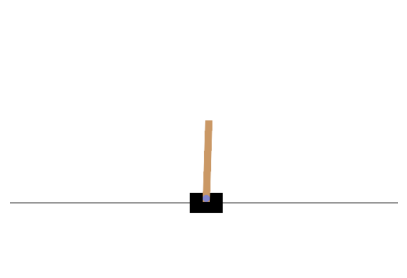

In [34]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

In [35]:

env.action_space

Discrete(2)

In [36]:

action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

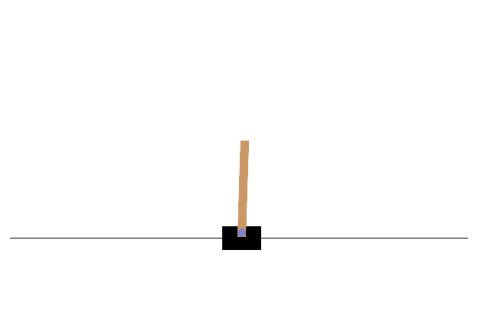

In [37]:
plot_environment(env)
save_fig("cart_pole_plot")
plt.show()

In [38]:

reward

1.0

In [39]:

done

False

In [40]:

truncated

False

In [41]:

if done or truncated:
    obs, info = env.reset()

## Hardcoded Policy

In [42]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [43]:
import numpy as np

np.mean(totals), np.std(totals), min(totals), max(totals)

(np.float64(41.698), np.float64(8.389445512070509), 24.0, 63.0)

In [44]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(basic_policy)

## Neural Network Policies

In [45]:
import tensorflow as tf

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

In [46]:
def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

## Policy Gradients

In [57]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

In [49]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

In [50]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [51]:

discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [52]:

discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [53]:

n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [54]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

In [55]:

optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [58]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # extra code – displays some debug info during training
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1}/{n_iterations},"
          f" mean rewards: {total_rewards / n_episodes_per_update:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

Iteration: 150/150, mean rewards: 189.1

In [59]:
np.random.seed(42)
show_one_episode(pg_policy)

## Markov Chains

In [60]:
np.random.seed(42)

transition_probabilities = [ # shape=[s, s']
        [0.7, 0.2, 0.0, 0.1],  # from s0 to s0, s1, s2, s3
        [0.0, 0.0, 0.9, 0.1],  # from s1 to s0, s1, s2, s3
        [0.0, 1.0, 0.0, 0.0],  # from s2 to s0, s1, s2, s3
        [0.0, 0.0, 0.0, 1.0]]  # from s3 to s0, s1, s2, s3

n_max_steps = 1000  # to avoid blocking in case of an infinite loop
terminal_states = [3]

def run_chain(start_state):
    current_state = start_state
    for step in range(n_max_steps):
        print(current_state, end=" ")
        if current_state in terminal_states:
            break
        current_state = np.random.choice(
            range(len(transition_probabilities)),
            p=transition_probabilities[current_state]
        )
    else:
        print("...", end="")

    print()

for idx in range(10):
    print(f"Run #{idx + 1}: ", end="")
    run_chain(start_state=0)

Run #1: 0 0 3 
Run #2: 0 1 2 1 2 1 2 1 2 1 3 
Run #3: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #4: 0 3 
Run #5: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #6: 0 1 3 
Run #7: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #8: 0 0 0 1 2 1 2 1 3 
Run #9: 0 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 3 
Run #10: 0 0 0 1 2 1 3 


## Markov Decision Process

In [61]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [62]:
Q_values = np.full((3, 3), -np.inf) 
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0

In [63]:
gamma = 0.90

history1 = [] 
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)])

history1 = np.array(history1)

In [64]:

Q_values

array([[18.91891892, 17.02702702, 13.62162162],
       [ 0.        ,        -inf, -4.87971488],
       [       -inf, 50.13365013,        -inf]])

In [65]:

Q_values.argmax(axis=1)

array([0, 0, 1])

## Q Learning

In [66]:

def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [67]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [68]:
np.random.seed(42)
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

In [69]:
alpha0 = 0.05 
decay = 0.005  
gamma = 0.90
state = 0 
history2 = []  

for iteration in range(10_000):
    history2.append(Q_values.copy()) 
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max() 
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)

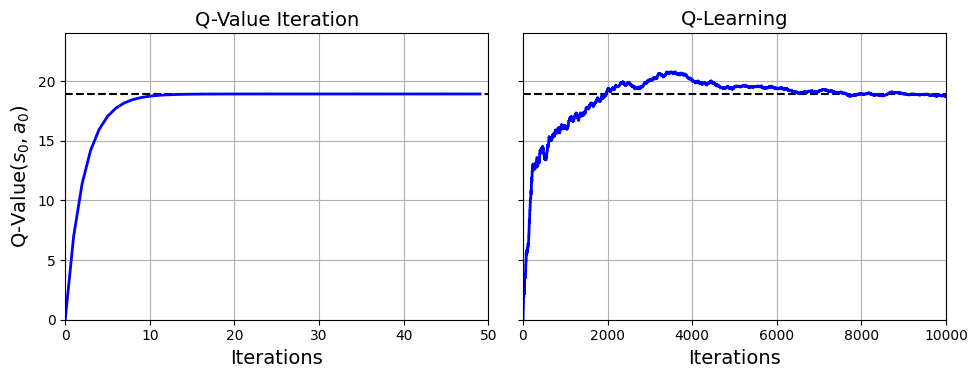

In [70]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

plt.show()

## Deep Q-Network

In [71]:
tf.random.set_seed(42)

input_shape = [4]
n_outputs = 2 

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-enrichment-repo-ray\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [72]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax()

In [73]:
from collections import deque

replay_buffer = deque(maxlen=2000)

In [74]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = np.empty(max_size, dtype=object)
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = np.random.randint(self.size, size=batch_size)
        return self.buffer[indices]

In [75]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(6)
    ]

In [76]:

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, truncated, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done, truncated))
    return next_state, reward, done, truncated, info

In [77]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

In [79]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mse

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [80]:
for episode in range(600):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, truncated, info = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights) 

Episode: 600, Steps: 200, eps: 0.010

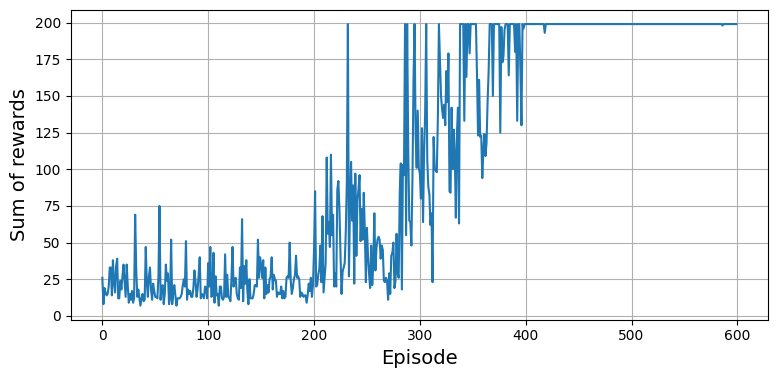

In [81]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
save_fig("dqn_rewards_plot")
plt.show()

In [82]:
show_one_episode(epsilon_greedy_policy)

## Fixed Q-Value

In [83]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-enrichment-repo-ray\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [84]:

target = tf.keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [86]:
env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mse

replay_buffer = deque(maxlen=2000)

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences
    next_Q_values = target.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones | truncateds) 
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [87]:
for episode in range(300):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:                        # <= CHANGED
            target.set_weights(model.get_weights())  # <= CHANGED

    #if episode > 50:
        #training_step(batch_size)
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index, online_weight in enumerate(online_weights):
        #    target_weights[index] = (0.99 * target_weights[index]
        #                             + 0.01 * online_weight)
        #target.set_weights(target_weights)

model.set_weights(best_weights)

Episode: 300, Steps: 45, eps: 0.4024

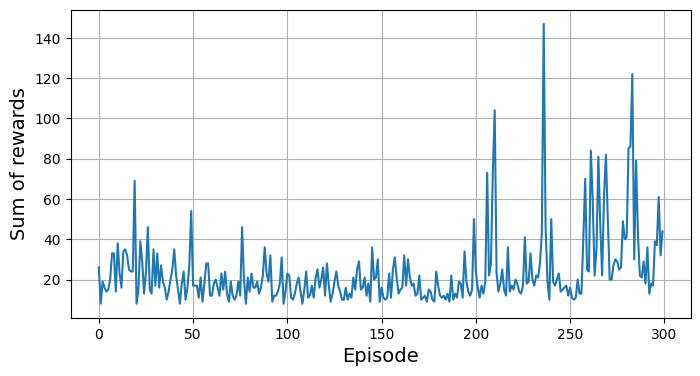

In [88]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [89]:
show_one_episode(epsilon_greedy_policy)

## Double DQN

In [90]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

target = tf.keras.models.clone_model(model)
target.set_weights(model.get_weights())

env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = [] 
best_score = 0

batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mse

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones, truncateds = experiences

    
    next_Q_values = model.predict(next_states, verbose=0) 
    best_next_actions = next_Q_values.argmax(axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    max_next_Q_values = (target.predict(next_states, verbose=0) * next_mask
                        ).sum(axis=1)
   

    runs = 1.0 - (dones | truncateds) 
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

replay_buffer = deque(maxlen=2000)

for episode in range(300):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-enrichment-repo-ray\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 300, Steps: 29, eps: 0.402

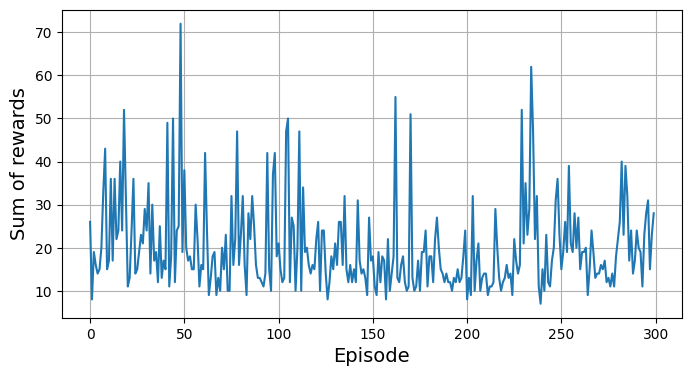

In [91]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [92]:
show_one_episode(epsilon_greedy_policy)

## Dueling Double DQN

In [96]:
tf.random.set_seed(42)

input_states = tf.keras.layers.Input(shape=[4])
hidden1 = tf.keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = tf.keras.layers.Dense(32, activation="elu")(hidden1)
state_values = tf.keras.layers.Dense(1)(hidden2)
raw_advantages = tf.keras.layers.Dense(n_outputs)(hidden2)
advantages = tf.keras.layers.Lambda(lambda x: x - tf.reduce_max(x, axis=1, keepdims=True))(raw_advantages)
Q_values = tf.keras.layers.Add()([state_values, advantages])
model = tf.keras.Model(inputs=[input_states], outputs=[Q_values])

In [98]:
batch_size = 32
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-3)
loss_fn = tf.keras.losses.mse

input_states_target = tf.keras.layers.Input(shape=[4])
hidden1_target = tf.keras.layers.Dense(32, activation="elu")(input_states_target)
hidden2_target = tf.keras.layers.Dense(32, activation="elu")(hidden1_target)
state_values_target = tf.keras.layers.Dense(1)(hidden2_target)
raw_advantages_target = tf.keras.layers.Dense(n_outputs)(hidden2_target)
advantages_target = tf.keras.layers.Lambda(lambda x: x - tf.reduce_max(x, axis=1, keepdims=True), 
                                         output_shape=(n_outputs,))(raw_advantages_target)
Q_values_target = tf.keras.layers.Add()([state_values_target, advantages_target])
target = tf.keras.Model(inputs=[input_states_target], outputs=[Q_values_target])
target.set_weights(model.get_weights())

env.reset(seed=42)
replay_buffer = deque(maxlen=2000)
rewards = []
best_score = 0

for episode in range(300):
    obs, info = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info, truncated = play_one_step(env, obs, epsilon)
        if done or truncated:
            break

    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 52, Steps: 25, eps: 0.898

c:\Users\USER\Documents\SchoolWork\College\8th\ML\ml-enrichment-repo-ray\.venv\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_42']
Received: inputs=Tensor(shape=(32, 4))
  warnings.warn(msg)


Episode: 300, Steps: 10, eps: 0.4020

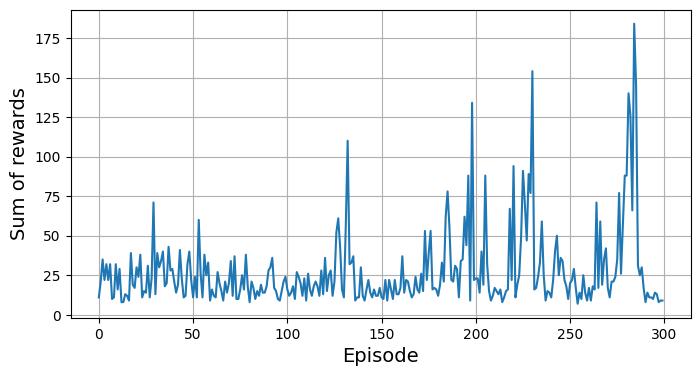

In [99]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.grid(True)
plt.show()

In [100]:
show_one_episode(epsilon_greedy_policy)

In [101]:
env.close()